In [1]:
import numpy as np
import pandas as pd
from sentence_transformers import util, SentenceTransformer
from tqdm.auto import tqdm
# Load data and embeddings
df = pd.read_csv("results/02_ai_scores_v2.csv")
emb = np.load("results/01_embeddings.npy")

# Load SBERT model
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")


E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(df.shape)
print(emb.shape)

(1200456, 11)
(1200456, 768)


clean the dataframe

In [3]:
def clean_df(df):
    """If dataframe has publisher/title columns, clean it."""
    if 'publisher' in df.columns and 'title' in df.columns:
        df = df.drop_duplicates(subset=['publisher', 'title'])
    return df

In [4]:
# Clean all dfs that contain news-level rows
df = clean_df(df)
# set ai score threshold to 0.5
df = df[df['is_ai'] == True].copy()
df = df[df['ai_score'] >= 0].copy()
# Filter the primary yearly dataframe
df = df[df['published_date'] >= '2016'].copy()


This paper identifies barriers using an inductive thematic analysis on 196 peer-reviewed studies, following PRISMA screening, with two independent coders extracting and grouping all challenge-related statements into recurring themes such as resistance to change, skills gaps, and data-quality/privacy issues.<Adoption and integration of AI in organizations-a systematic review of challenges and drivers towards future directions of research>

In [5]:
df.shape

(7063, 11)

In [6]:
barrier_queries = {
    "skills_gap":      "lack of AI skills, shortage of technical skills, insufficient expertise",
    "resistance":      "employee resistance, fear of automation, opposition to AI adoption",
    "privacy":         "data privacy, GDPR concerns, personal data protection issues",
    "data_quality":    "poor data quality, missing data, inconsistent datasets",
    "ethics_bias":     "algorithmic bias, fairness concerns, discrimination",
    "transparency":    "lack of model transparency, explainability issues, black-box AI"
}


In [7]:
emb = emb[df.index]

In [8]:
# Encode barrier queries
barrier_texts = list(barrier_queries.values())
barrier_emb = model.encode(barrier_texts, normalize_embeddings=True)

# Compute similarity
barrier_scores = util.cos_sim(emb, barrier_emb).cpu().numpy()

# Assign label with maximum similarity, with tqdm progress bar
b_type = []
argmax_indices = barrier_scores.argmax(axis=1)
keys = list(barrier_queries.keys())
for idx in tqdm(argmax_indices, desc="Classifying Barriers", total=barrier_scores.shape[0]):
    b_type.append(keys[idx])

df["barrier_type"] = b_type

df.to_csv("results/15_barrier_classification.csv", index=False)


Classifying Barriers: 100%|██████████| 7063/7063 [00:00<00:00, 2328410.69it/s]


search only from AI-related rows

In [9]:
ai_barriers = df[df["is_ai"]]["barrier_type"].value_counts()
ai_barriers.to_csv("results/16_barrier_distribution.csv")


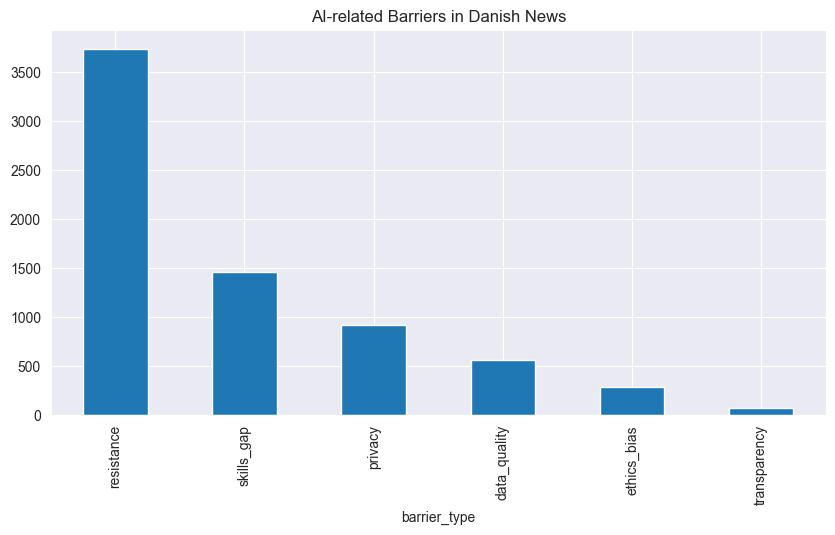

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
ai_barriers.plot(kind="bar")
plt.title("AI-related Barriers in Danish News")
plt.show()

plt.savefig("figures/plot.png", bbox_inches="tight")
plt.close()


In [11]:
print(df.shape)
print(emb.shape)

(7063, 12)
(7063, 768)


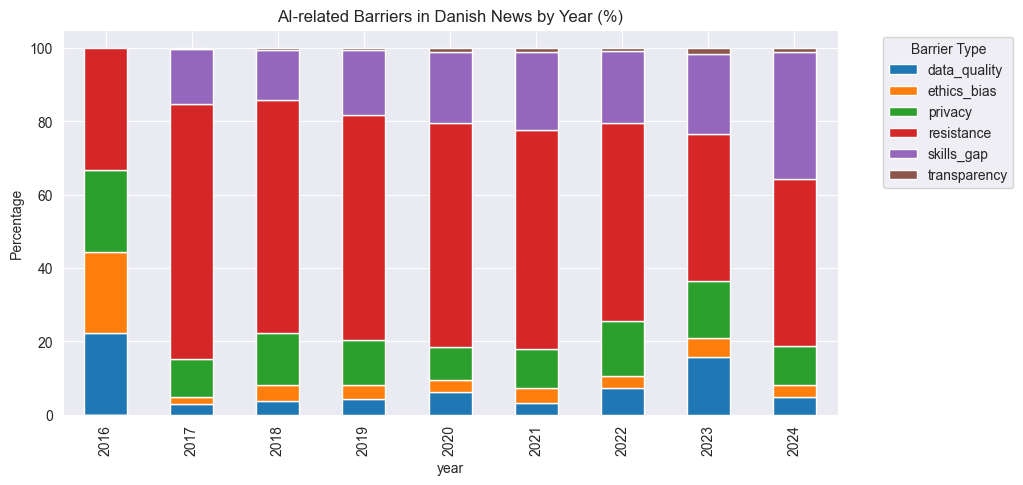

In [12]:
# AI-related Barriers in Danish News by Year in pct
df["year"] = pd.to_datetime(df["published_date"]).dt.year
barrier_year = df[df["is_ai"]].groupby(["year", "barrier_type"]).size().unstack(fill_value=0)
barrier_year_pct = barrier_year.div(barrier_year.sum(axis=1), axis=0) * 100
barrier_year_pct.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("AI-related Barriers in Danish News by Year (%)")
plt.ylabel("Percentage")
plt.legend(title="Barrier Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


trying using UMAP to detect clusters, explain barriers and events type

In [13]:
df

,plain_text,published_date,title,tags,categories,author,sitename,publisher,keyword_score,ai_score,is_ai,barrier_type,year
41,Danskerne opfatter Venstre som elitens parti. ...,2016-11-20,Venstre-profiler: Vi kan gøre mere for ikke at...,"venstre, eliten, Globalisering, Jakob Ellemann...",Samfund,Af Evander Pedersen,Kristeligt Dagblad,kristeligt-dagblad.dk,1,0.290533,True,ethics_bias,2016
425,Overlægerne render rundt med hovedet under arm...,2016-12-19,Ny teknologi giver ikke automatisk besparelser...,Innovation;Telemedicin,Nyheder,Line Emilie Fedders,Dagens Medicin,dagensmedicin.dk,2,0.330144,True,resistance,2016
1069,Det er blevet en tradition på Undertoner at sæ...,2016-11-29,Uden for nummer 2016 del 1,NaN,NaN,Singer; Songwriter,Undertoner.dk,undertoner.dk,1,0.246074,True,data_quality,2016
1238,Den travleste musiker på årets festival har ut...,2016-07-09,Roskilde Festival 2016: Greg Fox – »I den musi...,NaN,NaN,Singer; Songwriter,Undertoner.dk,undertoner.dk,1,0.283538,True,data_quality,2016
1730,Grænserne mellem hvad der er virkeligt og virt...,2016-12-27,Frontløbere spår virtuel invasion af virkeligh...,NaN,NaN,Af Ritzau,Sndk_Nyheder,sn.dk,2,0.335831,True,resistance,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200193,Lastvogn i XXL-udgave får 780 heste til de tun...,2024-01-30,Lastvogn i XXL-udgave får 780 heste til de tun...,"lastbiler, skibe, skibsfart, søfart, søtranspo...",NaN,NaN,transportnyhederne.dk » Vejtransport,transportnyhederne.dk,1,0.215379,True,resistance,2024
1200268,"Danske forskere har fundet frem til en metode,...",2024-01-16,Han er 76 år og professor i kunstig intelligen...,Kunstig intelligens;Kræft;Kræftforskning;Blodp...,Nyheder,Marie Bebe,Berlingske.dk,berlingske.dk,1,0.344000,True,data_quality,2024
1200297,Frygten for kunstig intelligens risikerer at s...,2024-01-18,Konsulenthus finder enormt potentiale i den of...,Offentligt forbrug;Offentlige sektor;Kunstig i...,Business,Kalle Kehlet; Linda Kastrup,Berlingske.dk,berlingske.dk,1,0.419850,True,resistance,2024
1200379,Elektrisk lastbil er eneste udgave af ny model...,2024-01-31,Elektrisk lastbil er eneste udgave af ny model...,"lastbiler, skibe, skibsfart, søfart, søtranspo...",NaN,NaN,transportnyhederne.dk » Vejtransport,transportnyhederne.dk,1,0.240227,True,resistance,2024


In [14]:
from umap import UMAP

# df filter only AI-related rows, apply UMAP on embeddings

print(df.shape)
print(emb.shape)
reduced = UMAP(n_neighbors=15, min_dist=0.0, metric="cosine").fit_transform(emb)


(7063, 13)
(7063, 768)


In [15]:
# mkdir results_cluster
import os
os.makedirs("results_cluster", exist_ok=True)
np.save("results_cluster/01_umap_reduced.npy", reduced)


In [16]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=40, metric='euclidean')
labels = clusterer.fit_predict(reduced)


E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
E:\Projects\AI-DK-Media-project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [17]:
df

,plain_text,published_date,title,tags,categories,author,sitename,publisher,keyword_score,ai_score,is_ai,barrier_type,year
41,Danskerne opfatter Venstre som elitens parti. ...,2016-11-20,Venstre-profiler: Vi kan gøre mere for ikke at...,"venstre, eliten, Globalisering, Jakob Ellemann...",Samfund,Af Evander Pedersen,Kristeligt Dagblad,kristeligt-dagblad.dk,1,0.290533,True,ethics_bias,2016
425,Overlægerne render rundt med hovedet under arm...,2016-12-19,Ny teknologi giver ikke automatisk besparelser...,Innovation;Telemedicin,Nyheder,Line Emilie Fedders,Dagens Medicin,dagensmedicin.dk,2,0.330144,True,resistance,2016
1069,Det er blevet en tradition på Undertoner at sæ...,2016-11-29,Uden for nummer 2016 del 1,NaN,NaN,Singer; Songwriter,Undertoner.dk,undertoner.dk,1,0.246074,True,data_quality,2016
1238,Den travleste musiker på årets festival har ut...,2016-07-09,Roskilde Festival 2016: Greg Fox – »I den musi...,NaN,NaN,Singer; Songwriter,Undertoner.dk,undertoner.dk,1,0.283538,True,data_quality,2016
1730,Grænserne mellem hvad der er virkeligt og virt...,2016-12-27,Frontløbere spår virtuel invasion af virkeligh...,NaN,NaN,Af Ritzau,Sndk_Nyheder,sn.dk,2,0.335831,True,resistance,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200193,Lastvogn i XXL-udgave får 780 heste til de tun...,2024-01-30,Lastvogn i XXL-udgave får 780 heste til de tun...,"lastbiler, skibe, skibsfart, søfart, søtranspo...",NaN,NaN,transportnyhederne.dk » Vejtransport,transportnyhederne.dk,1,0.215379,True,resistance,2024
1200268,"Danske forskere har fundet frem til en metode,...",2024-01-16,Han er 76 år og professor i kunstig intelligen...,Kunstig intelligens;Kræft;Kræftforskning;Blodp...,Nyheder,Marie Bebe,Berlingske.dk,berlingske.dk,1,0.344000,True,data_quality,2024
1200297,Frygten for kunstig intelligens risikerer at s...,2024-01-18,Konsulenthus finder enormt potentiale i den of...,Offentligt forbrug;Offentlige sektor;Kunstig i...,Business,Kalle Kehlet; Linda Kastrup,Berlingske.dk,berlingske.dk,1,0.419850,True,resistance,2024
1200379,Elektrisk lastbil er eneste udgave af ny model...,2024-01-31,Elektrisk lastbil er eneste udgave af ny model...,"lastbiler, skibe, skibsfart, søfart, søtranspo...",NaN,NaN,transportnyhederne.dk » Vejtransport,transportnyhederne.dk,1,0.240227,True,resistance,2024


In [18]:
import joblib
from tqdm.auto import tqdm
df["cluster"] = labels
df.reset_index(drop=True, inplace=True)
df.to_csv("results_cluster/02_cluster_labels.csv", index=False)
print("✔ Saved cluster labels to results_cluster/02_cluster_labels.csv")

joblib.dump(clusterer, "results_cluster/clusterer.pkl")
print("✔ Saved HDBSCAN model")


# ============ 3) Compute Cluster Centroids ============

print("Computing cluster centroids…")

unique_clusters = sorted([c for c in set(labels) if c != -1])
centroids = {}

for cid in tqdm(unique_clusters, desc="Centroids"):
    idx = np.where(labels == cid)[0]
    vecs = emb[idx]
    centroid = vecs.mean(axis=0)
    centroid /= np.linalg.norm(centroid)
    centroids[cid] = centroid

np.save("results_cluster/03_cluster_centroids.npy", centroids)
print("✔ Saved centroids")


# ============ 4) Extract Representative Documents ============

print("Finding representative texts…")

representatives = {}

for cid in tqdm(unique_clusters, desc="Representatives"):
    idx = np.where(labels == cid)[0]
    vecs = emb[idx]
    centroid = centroids[cid]

    sims = vecs @ centroid
    top_k_idx = idx[np.argsort(-sims)[:5]]

    representatives[int(cid)] = df.loc[top_k_idx, "plain_text"].tolist()

# Save as JSON
import json
with open("results_cluster/04_representatives.json", "w", encoding="utf-8") as f:
    json.dump(representatives, f, ensure_ascii=False, indent=2)

print("✔ Saved representative texts")


# ============ 5) Auto-generate Cluster Label Sentences ============

print("Generating cluster summary sentences…")

summaries = {}
for cid in tqdm(unique_clusters, desc="Label Summary"):
    reps = representatives[int(cid)]   # ensure int index
    summaries[int(cid)] = reps[0] if len(reps) > 0 else ""

# Save JSON
import json
with open("results_cluster/05_cluster_label_sentences.json", "w", encoding="utf-8") as f:
    json.dump(summaries, f, ensure_ascii=False, indent=2)

print("✔ Saved cluster labeling sentences")


# ============ 6) Export Full Summary Table ============

summary_rows = []
for cid in unique_clusters:
    summary_rows.append({
        "cluster_id": cid,
        "size": (df["cluster"] == cid).sum(),
        "label_sentence": summaries[cid],
        "representatives": representatives[cid]
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv("results_cluster/06_cluster_summary_table.csv", index=False)

print("✔ Full summary saved to 06_cluster_summary_table.csv")
print("🎉 All steps completed!")


✔ Saved cluster labels to results_cluster/02_cluster_labels.csv
✔ Saved HDBSCAN model
Computing cluster centroids…


Centroids: 100%|██████████| 30/30 [00:00<00:00, 3269.39it/s]


✔ Saved centroids
Finding representative texts…


Representatives: 100%|██████████| 30/30 [00:00<00:00, 2047.60it/s]


✔ Saved representative texts
Generating cluster summary sentences…


Label Summary: 100%|██████████| 30/30 [00:00<?, ?it/s]

✔ Saved cluster labeling sentences
✔ Full summary saved to 06_cluster_summary_table.csv
🎉 All steps completed!


In [19]:
df.shape
# total labels count
len(set(labels))

31